In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pandas numpy torch torch-geometric scikit-learn matplotlib optuna tensorflow keras-tuner scipy tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.5 MB/s eta 0:00:00


In [23]:
import pandas as pd
import numpy as np
import torch
import gc
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from scipy.spatial import cKDTree
from torch_geometric.nn import SAGEConv
import torch.optim as optim
from tqdm import tqdm
from tensorflow.keras.models import load_model
import os

file_path = '/content/drive/MyDrive/EMTF/S&P 500 Historical Data weekly.csv'
#file_path = '/content/drive/MyDrive/EMTF/EUR_USD Historical Data 2.csv'
data = pd.read_csv(file_path)


In [24]:
full_data = data.copy()

full_data = data.iloc[:, [0, 1,-1]]

# Preprocess function
def preprocess_data(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.sort_values(['Date'])
    return data

preprocessed_data = preprocess_data(full_data)

# Define the percentage split (you can modify these percentages as per your requirement)
train_size = 0.6  # 70% for training
val_size = 0.2  # 15% for validation
test_size = 0.2  # 15% for testing

# Calculate the number of data points for each split
total_rows = preprocessed_data.shape[0]



train_split = int(total_rows * train_size)
val_split = train_split + int(total_rows * val_size)

# Split the dataset by index based on the calculated splits
train_data = preprocessed_data.iloc[:train_split]
val_data = preprocessed_data.iloc[train_split:val_split]
test_data = preprocessed_data.iloc[val_split:]

<ipython-input-24-d2fc9762c549>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


In [27]:
train_data.head()

,Date,Price,Change %
1043,2004-10-10,"1,108.20",-1.24%
1042,2004-10-17,"1,095.70",-1.13%
1041,2004-10-24,"1,130.20",3.15%
1040,2004-10-31,"1,166.20",3.19%
1039,2004-11-07,"1,184.20",1.54%


S&P500

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Train Loss: 1.0784, Valid Loss: 1.2792, LR: 0.001
Epoch [20/100], Train Loss: 0.9860, Valid Loss: 1.2383, LR: 0.001
Epoch [30/100], Train Loss: 0.7347, Valid Loss: 1.2587, LR: 0.0005
Epoch [40/100], Train Loss: 0.5924, Valid Loss: 1.2919, LR: 0.00025
Epoch [50/100], Train Loss: 0.5236, Valid Loss: 1.3523, LR: 6.25e-05
Epoch [60/100], Train Loss: 0.5032, Valid Loss: 1.3625, LR: 3.125e-05
Epoch [70/100], Train Loss: 0.4951, Valid Loss: 1.3706, LR: 7.8125e-06
Epoch [80/100], Train Loss: 0.4927, Valid Loss: 1.3737, LR: 1.953125e-06
Epoch [90/100], Train Loss: 0.4920, Valid Loss: 1.3741, LR: 9.765625e-07
Epoch [100/100], Train Loss: 0.4918, Valid Loss: 1.3742, LR: 2.44140625e-07
Mean Absolute Error: 0.0208
Mean Absolute Percentage Error: 54891912.5000%
R-squared: -0.7006


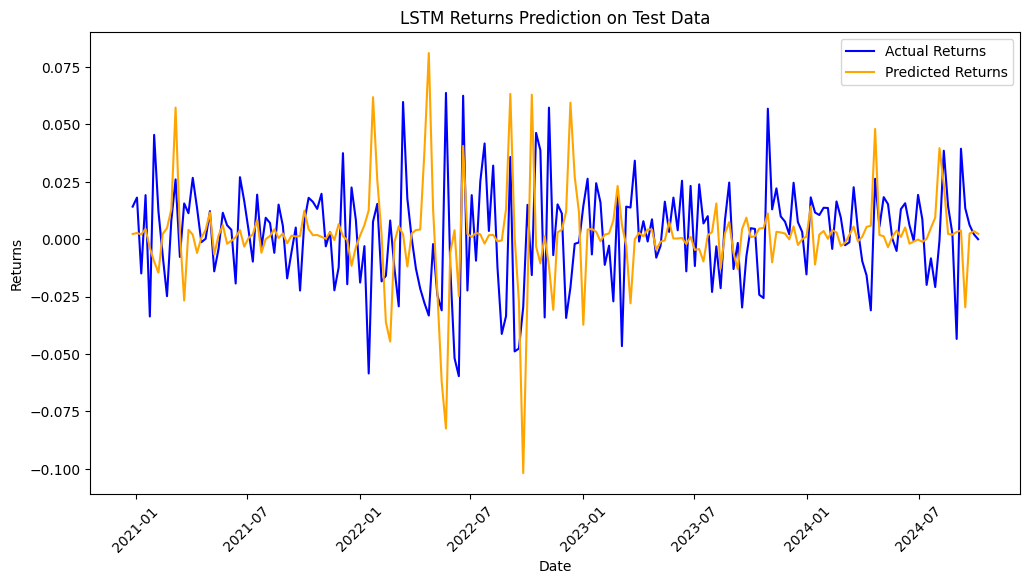

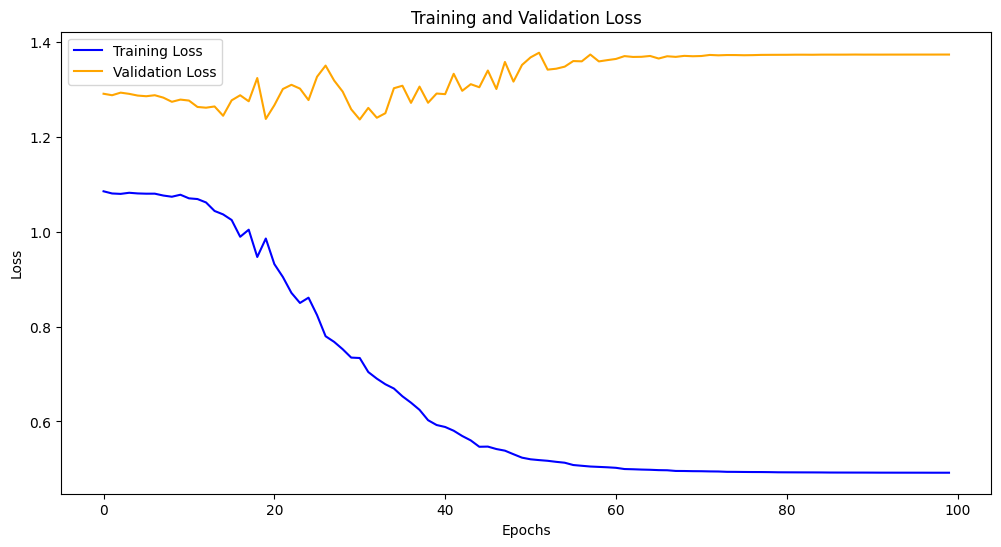

In [28]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, RobustScaler
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import torch.optim as optim  # Add this import for optimizers

# Define the column name variable
COLUMN_NAME = 'Change %'

def convert_to_float(df):
    try:
        # Remove commas and percentage signs, then convert to float
        df[COLUMN_NAME] = df[COLUMN_NAME].str.replace(',', '')  # Remove commas
        df[COLUMN_NAME] = df[COLUMN_NAME].str.replace('%', '')   # Remove percent sign if applicable
        df[COLUMN_NAME] = df[COLUMN_NAME].astype(float)

        # If the COLUMN_NAME is 'Change %', calculate log returns
        if COLUMN_NAME == 'Change %':
            df[COLUMN_NAME] = np.log(1 + (df[COLUMN_NAME] / 100))  # Convert percentage to decimal and then to log returns
            df.dropna(inplace=True)  # Drop NaN values after calculating returns
    except Exception as e:
        print(f"Error converting to float: {e}")
    return df


# Prepare data for LSTM
train_data_lstm = train_data[['Date', COLUMN_NAME]].copy()
valid_data_lstm = val_data[['Date', COLUMN_NAME]].copy()  # Ensure validation data is included
test_data_lstm = test_data[['Date', COLUMN_NAME]].copy()

# Apply conversion
train_data_lstm = convert_to_float(train_data_lstm)
valid_data_lstm = convert_to_float(valid_data_lstm)
test_data_lstm = convert_to_float(test_data_lstm)

# Scale returns to the range [0, 1]
scaler = RobustScaler()
train_data_lstm[COLUMN_NAME] = scaler.fit_transform(train_data_lstm[[COLUMN_NAME]].values)
valid_data_lstm[COLUMN_NAME] = scaler.transform(valid_data_lstm[[COLUMN_NAME]].values)
test_data_lstm[COLUMN_NAME] = scaler.transform(test_data_lstm[[COLUMN_NAME]].values)

# Define TimeSeriesDataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length, dates=None):
        self.data = data.values
        self.seq_length = seq_length
        self.dates = dates  # Dates will be used only for testing

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]  # Get sequence of returns
        y = self.data[idx + self.seq_length]      # Get the target return
        if self.dates is not None:  # If dates are provided (for test data)
            date = self.dates.iloc[idx + self.seq_length]  # Get corresponding date
            return torch.FloatTensor(x), torch.FloatTensor([y]), date
        return torch.FloatTensor(x), torch.FloatTensor([y])  # Return only x and y during training/validation

# Parameters
SEQ_LENGTH = 12  # Number of past returns to use for prediction
BATCH_SIZE = 1
NUM_EPOCHS = 100
INITIAL_LR = 0.001
L2_REGULARIZATION = 1e-5  # L2 regularization factor
PATIENCE = 5  # How many epochs to wait before reducing LR
GAMMA = 0.5  # Factor by which to reduce LR

# Create datasets
train_dataset = TimeSeriesDataset(train_data_lstm[COLUMN_NAME], SEQ_LENGTH)  # No dates needed for training
valid_dataset = TimeSeriesDataset(valid_data_lstm[COLUMN_NAME], SEQ_LENGTH)  # No dates for validation
test_dataset = TimeSeriesDataset(test_data_lstm[COLUMN_NAME], SEQ_LENGTH, test_data_lstm['Date'])  # Include dates for test

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)  # Validation DataLoader
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# LSTM Model remains unchanged
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 32)  # First dense layer
        self.fc2 = nn.Linear(32, 1)  # Output layer

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = out[:, -1, :]  # Take the output of the last time step
        out = self.fc1(out)  # Pass through the first dense layer
        out = torch.relu(out)  # Apply activation function
        out = self.fc2(out)  # Pass through the output layer
        return out

# Initialize model, optimizer, criterion, and scheduler
model = LSTMModel()
optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR, weight_decay=L2_REGULARIZATION)
criterion = nn.MSELoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=GAMMA, patience=PATIENCE, verbose=True)

# Training loop with validation (modified to ignore dates during training)
train_loss = []  # List to track average loss per epoch
valid_loss = []  # List to track validation loss

for epoch in range(NUM_EPOCHS):
    model.train()  # Set the model to training mode
    epoch_loss = 0

    # Training phase
    for i, (x_batch, y_batch) in enumerate(train_loader):  # No date in train_loader
        x_batch = x_batch.unsqueeze(-1)  # Correct input shape to (batch_size, seq_length, 1)
        optimizer.zero_grad()  # Clear gradients
        outputs = model(x_batch)  # Forward pass
        loss = criterion(outputs, y_batch.unsqueeze(-1))  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)  # Average loss for the epoch
    train_loss.append(avg_loss)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    epoch_valid_loss = 0

    with torch.no_grad():  # Disable gradient tracking for validation
        for x_batch, y_batch in valid_loader:  # No date in valid_loader
            x_batch = x_batch.unsqueeze(-1)  # Correct input shape for LSTM
            outputs = model(x_batch)  # Forward pass
            loss = criterion(outputs, y_batch.unsqueeze(-1))  # Compute validation loss
            epoch_valid_loss += loss.item()

    avg_valid_loss = epoch_valid_loss / len(valid_loader)  # Average validation loss
    valid_loss.append(avg_valid_loss)

    # Step the scheduler to adjust the learning rate based on validation loss
    scheduler.step(avg_valid_loss)

    # Print losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Train Loss: {avg_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]}')

# Define a custom collate function to handle dates separately
def custom_collate_fn(batch):
    x_batch = torch.stack([item[0] for item in batch])  # Stack input tensors
    y_batch = torch.stack([item[1] for item in batch])  # Stack target tensors
    dates = [item[2] for item in batch]  # Extract dates
    return x_batch, y_batch, dates

# Updated DataLoader for test data with the custom collate function
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)

# Test phase (dates included in test_loader)
model.eval()
with torch.no_grad():
    test_predictions = []
    actuals = []
    dates = []  # To store dates

    for x_batch, y_batch, date_batch in test_loader:  # Use date_batch instead of date
        x_batch = x_batch.unsqueeze(-1)  # Correct input shape for LSTM
        outputs = model(x_batch)  # Forward pass
        test_predictions.append(outputs.numpy())  # Append predictions
        actuals.append(y_batch.numpy())  # Append actual values
        dates.extend(date_batch)  # Append corresponding dates

# Convert lists to numpy arrays for easy manipulation
test_predictions = np.concatenate(test_predictions)
actuals = np.concatenate(actuals)

# Convert dates to a pandas datetime format
dates = pd.to_datetime(dates)

# Inverse scale predictions and actual values
test_predictions = scaler.inverse_transform(test_predictions)
actuals = scaler.inverse_transform(actuals.reshape(-1, 1))

# Calculate MAE, MAPE, and R-squared
mae = mean_absolute_error(actuals, test_predictions)
mape = np.mean(np.abs((actuals - test_predictions) / actuals)) * 100  # Calculate MAPE
r_squared = r2_score(actuals, test_predictions)

# Print metrics
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Absolute Percentage Error: {mape:.4f}%')
print(f'R-squared: {r_squared:.4f}')

# Visualize the results with dates on the x-axis
plt.figure(figsize=(12, 6))
plt.plot(dates, actuals, label='Actual Returns', color='blue')
plt.plot(dates, test_predictions, label='Predicted Returns', color='orange')
plt.title('LSTM Returns Prediction on Test Data')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.show()

# Optionally, plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(valid_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


FOREX EUR/USD




Error converting to float: Can only use .str accessor with string values!
Error converting to float: Can only use .str accessor with string values!
Error converting to float: Can only use .str accessor with string values!


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/50], Train Loss: 0.0015, Valid Loss: 0.0004, LR: [0.001]
Epoch [20/50], Train Loss: 0.0012, Valid Loss: 0.0004, LR: [0.0003]
Epoch [30/50], Train Loss: 0.0011, Valid Loss: 0.0004, LR: [2.6999999999999996e-05]
Epoch [40/50], Train Loss: 0.0011, Valid Loss: 0.0004, LR: [2.4299999999999996e-06]
Epoch [50/50], Train Loss: 0.0011, Valid Loss: 0.0004, LR: [7.289999999999998e-07]
Mean Absolute Error: 0.0110
Mean Absolute Percentage Error: 1.0272%
R-squared: 0.9331


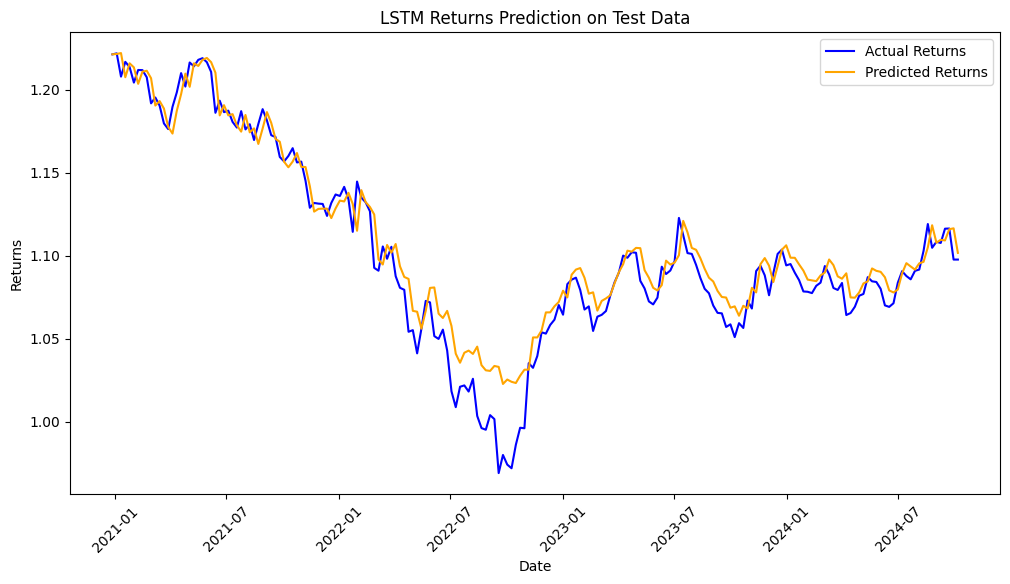

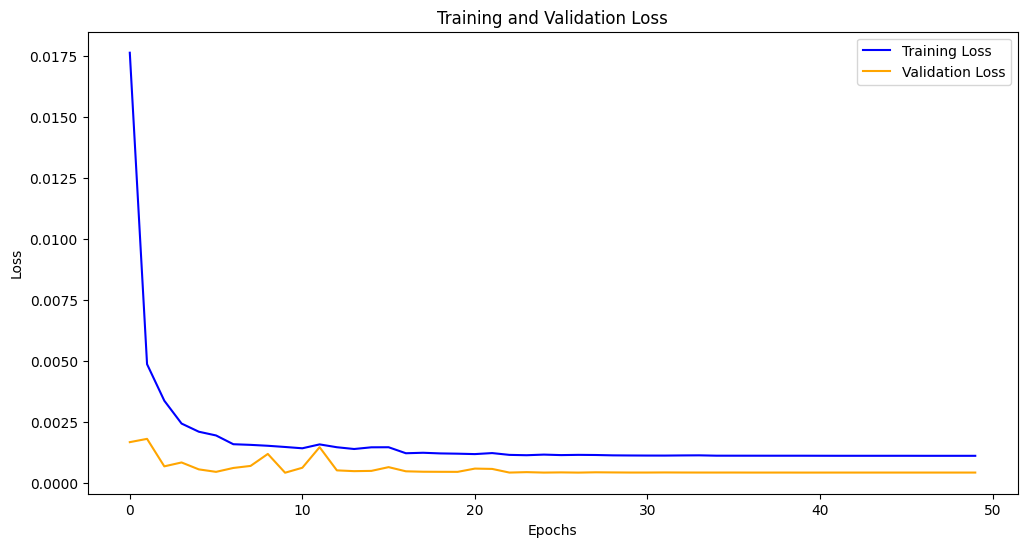

In [20]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# Define the column name variable
COLUMN_NAME = 'Price'

# Convert COLUMN_NAME strings to float with error handling
def convert_to_float(df):
    try:
        df[COLUMN_NAME] = df[COLUMN_NAME].str.replace(',', '')  # Remove commas
        df[COLUMN_NAME] = df[COLUMN_NAME].astype(float)
    except Exception as e:
        print(f"Error converting to float: {e}")
    return df

# Prepare data for LSTM
train_data_lstm = train_data[['Date', COLUMN_NAME]].copy()
valid_data_lstm = val_data[['Date', COLUMN_NAME]].copy()  # Ensure validation data is included
test_data_lstm = test_data[['Date', COLUMN_NAME]].copy()

# Apply conversion
train_data_lstm = convert_to_float(train_data_lstm)
valid_data_lstm = convert_to_float(valid_data_lstm)
test_data_lstm = convert_to_float(test_data_lstm)

# Scale returns to the range [0, 1]
scaler = MinMaxScaler()
train_data_lstm[COLUMN_NAME] = scaler.fit_transform(train_data_lstm[[COLUMN_NAME]].values)
valid_data_lstm[COLUMN_NAME] = scaler.transform(valid_data_lstm[[COLUMN_NAME]].values)
test_data_lstm[COLUMN_NAME] = scaler.transform(test_data_lstm[[COLUMN_NAME]].values)

# Define TimeSeriesDataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length, dates=None):
        self.data = data.values
        self.seq_length = seq_length
        self.dates = dates  # Dates will be used only for testing

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]  # Get sequence of returns
        y = self.data[idx + self.seq_length]      # Get the target return
        if self.dates is not None:  # If dates are provided (for test data)
            date = self.dates.iloc[idx + self.seq_length]  # Get corresponding date
            return torch.FloatTensor(x), torch.FloatTensor([y]), date
        return torch.FloatTensor(x), torch.FloatTensor([y])  # Return only x and y during training/validation

# Parameters
SEQ_LENGTH = 12  # Number of past returns to use for prediction
BATCH_SIZE = 1
NUM_EPOCHS = 50
INITIAL_LR = 0.001
L2_REGULARIZATION = 1e-5  # L2 regularization factor
PATIENCE = 5  # How many epochs before reducing LR
GAMMA = 0.3  # Factor by which to reduce LR

# Create datasets
train_dataset = TimeSeriesDataset(train_data_lstm[COLUMN_NAME], SEQ_LENGTH)  # No dates needed for training
valid_dataset = TimeSeriesDataset(valid_data_lstm[COLUMN_NAME], SEQ_LENGTH)  # No dates for validation
test_dataset = TimeSeriesDataset(test_data_lstm[COLUMN_NAME], SEQ_LENGTH, test_data_lstm['Date'])  # Include dates for test

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)  # Validation DataLoader
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# LSTM Model remains unchanged
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 32)  # First dense layer
        self.fc2 = nn.Linear(32, 1)  # Output layer

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = out[:, -1, :]  # Take the output of the last time step
        out = self.fc1(out)  # Pass through the first dense layer
        out = torch.relu(out)  # Apply activation function
        out = self.fc2(out)  # Pass through the output layer
        return out

# Initialize model, optimizer, criterion, and scheduler
model = LSTMModel()
optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR, weight_decay=L2_REGULARIZATION)
criterion = nn.MSELoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=GAMMA, patience=PATIENCE, verbose=True)

# Training loop with validation
train_loss = []  # List to track average loss per epoch
valid_loss = []  # List to track validation loss

for epoch in range(NUM_EPOCHS):
    model.train()  # Set the model to training mode
    epoch_loss = 0

    # Training phase
    for i, (x_batch, y_batch) in enumerate(train_loader):  # No date in train_loader
        x_batch = x_batch.unsqueeze(-1)  # Correct input shape to (batch_size, seq_length, 1)
        optimizer.zero_grad()  # Clear gradients
        outputs = model(x_batch)  # Forward pass
        loss = criterion(outputs, y_batch.unsqueeze(-1))  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)  # Average loss for the epoch
    train_loss.append(avg_loss)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    epoch_valid_loss = 0

    with torch.no_grad():  # Disable gradient tracking for validation
        for x_batch, y_batch in valid_loader:  # No date in valid_loader
            x_batch = x_batch.unsqueeze(-1)  # Correct input shape for LSTM
            outputs = model(x_batch)  # Forward pass
            loss = criterion(outputs, y_batch.unsqueeze(-1))  # Compute validation loss
            epoch_valid_loss += loss.item()

    avg_valid_loss = epoch_valid_loss / len(valid_loader)  # Average validation loss
    valid_loss.append(avg_valid_loss)

    # Step the scheduler to adjust the learning rate
    scheduler.step(avg_valid_loss)

    # Print losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Train Loss: {avg_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}, LR: {scheduler.get_last_lr()}')

# Continue with the test phase and plotting (unchanged from your original code)..
# Define a custom collate function to handle dates separately
def custom_collate_fn(batch):
    x_batch = torch.stack([item[0] for item in batch])  # Stack input tensors
    y_batch = torch.stack([item[1] for item in batch])  # Stack target tensors
    dates = [item[2] for item in batch]  # Extract dates
    return x_batch, y_batch, dates

# Updated DataLoader for test data with the custom collate function
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)

# Test phase (dates included in test_loader)
model.eval()
with torch.no_grad():
    test_predictions = []
    actuals = []
    dates = []  # To store dates

    for x_batch, y_batch, date_batch in test_loader:  # Use date_batch instead of date
        x_batch = x_batch.unsqueeze(-1)  # Correct input shape for LSTM
        outputs = model(x_batch)  # Forward pass
        test_predictions.append(outputs.numpy())  # Append predictions
        actuals.append(y_batch.numpy())  # Append actual values
        dates.extend(date_batch)  # Append corresponding dates

# Convert lists to numpy arrays for easy manipulation
test_predictions = np.concatenate(test_predictions)
actuals = np.concatenate(actuals)

# Convert dates to a pandas datetime format
dates = pd.to_datetime(dates)

# Inverse scale predictions and actual values
test_predictions = scaler.inverse_transform(test_predictions)
actuals = scaler.inverse_transform(actuals.reshape(-1, 1))

# Calculate MAE, MAPE, and R-squared
mae = mean_absolute_error(actuals, test_predictions)
mape = np.mean(np.abs((actuals - test_predictions) / actuals)) * 100  # Calculate MAPE
r_squared = r2_score(actuals, test_predictions)

# Print metrics
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Absolute Percentage Error: {mape:.4f}%')
print(f'R-squared: {r_squared:.4f}')

# Visualize the results with dates on the x-axis
plt.figure(figsize=(12, 6))
plt.plot(dates, actuals, label='Actual Returns', color='blue')
plt.plot(dates, test_predictions, label='Predicted Returns', color='orange')
plt.title('LSTM Returns Prediction on Test Data')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.show()

# Optionally, plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(valid_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

